In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [18]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])


In [19]:
train = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [55]:
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784))
           )

In [21]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.train_data
train_data = train.data/255

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', torch.tensor(train.data).size())
print(' - min:', torch.min(torch.tensor(train_data)))
print(' - max:', torch.max(torch.tensor(train_data)))
print(' - mean:', train_data.mean(axis = (0,1,2)))
print(' - std:', train_data.std(axis = (0,1,2)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0., dtype=torch.float64)
 - max: tensor(1., dtype=torch.float64)
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
torch.Size([512, 3, 32, 32])
torch.Size([512])


tensor([[ 1.3762,  1.4239,  1.5032,  ...,  1.3445,  1.3604,  1.3921],
        [ 1.3286,  1.3604,  1.4080,  ...,  1.2492,  1.2651,  1.2810],
        [ 1.3604,  1.3762,  1.4239,  ...,  1.2334,  1.2651,  1.2651],
        ...,
        [ 0.9794,  0.9476, -0.3224,  ...,  1.6620,  1.7096,  1.7255],
        [ 1.0746,  1.0746,  0.9000,  ...,  1.7096,  1.7413,  1.8048],
        [ 1.4874,  1.4874,  1.5350,  ...,  1.7572,  1.8048,  1.8366]])
2 tensor([[ 1.5792,  1.6114,  1.6597,  ...,  1.5309,  1.5631,  1.5953],
        [ 1.5309,  1.5309,  1.5631,  ...,  1.4342,  1.4503,  1.4825],
        [ 1.5470,  1.5470,  1.5631,  ...,  1.4181,  1.4503,  1.4342],
        ...,
        [ 1.0799,  0.8544, -0.6918,  ...,  1.7241,  1.7886,  1.8208],
        [ 1.1121,  1.0960,  0.8866,  ...,  1.7725,  1.8047,  1.8852],
        [ 1.5470,  1.5792,  1.6436,  ...,  1.8691,  1.9335,  1.9979]])
3 tensor([[ 1.6361,  1.6661,  1.7260,  ...,  1.5911,  1.5911,  1.5911],
        [ 1.6211,  1.6361,  1.6661,  ...,  1.5161,  1.5161

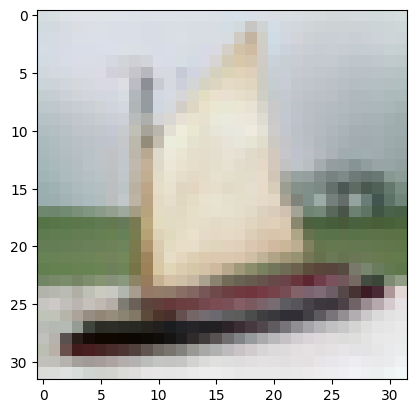

In [22]:
def imshow(img):
    print(img[0])
    print('2', img[1])
    print('3', img[2])
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images[:1]))


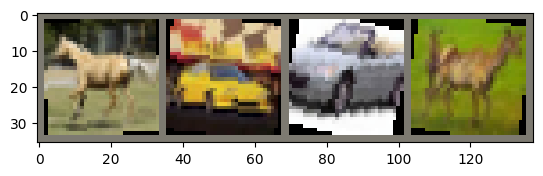

horse car   car   deer 


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=1, padding=1, bias=False),  #28>>28 | 1>>3 | 1>>1
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=False),#28>>28 | 3>>5 | 1>>1
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1)

        )
        # Transition Block 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(64, 16, 1, stride =1,padding=0, bias=False),  #28>>28 | 3>>3 | 1>>1
            #nn.ReLU(),
            #nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.MaxPool2d(2, 2),#28>>14 | 5>>6 | 1>>2

        )
        # Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=1, bias=False), #12>>10 | 10>>14 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 16, 3, stride=1, padding=1, bias=False), #10>>8 | 14>>18 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, stride=1, padding=1, bias=False), #8>>6 | 18>>22 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

        )
        # Transition Block 2
        self.trans2 = nn.Sequential(
            nn.Conv2d(32, 16, 1, stride=1, bias=False),#12>>12 | 10>>10 | 2>>2
            #nn.ReLU(),
            #nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.MaxPool2d(2, 2),#28>>14 | 5>>6 | 1>>2

        )

        # Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=0, bias=False), #12>>10 | 10>>14 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, stride=1, padding=0, bias=False), #10>>8 | 14>>18 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            nn.Conv2d(32, 32, 3, stride=1, padding=0, bias=False), #8>>6 | 18>>22 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

        )

        self.fc = nn.Sequential(
            nn.Conv2d(32, 10, 1, stride=1, padding=0, bias=False), #6>>6 | 22>>26 | 2>>2
            #nn.ReLU(),
            #nn.BatchNorm2d(1),
            #nn.Dropout(0.05),
            #nn.Linear(10, 10)

        )
        self.gap = nn.Sequential(
            #nn.AvgPool2d(kernel_size=16)
            nn.AdaptiveAvgPool2d((1, 1))
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        #x = self.norm4(x)
        #print('SIze', x.size)
        #x = x.view(-1, 3200)

        #x = x.view(x.size(0), -1)

        x = self.gap(x)
        x = self.fc(x)
        #x = self.gpool(x)
        x = x.view(-1, 10)
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [31]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           4,800
              ReLU-2           [-1, 64, 30, 30]               0
       BatchNorm2d-3           [-1, 64, 30, 30]             128
           Dropout-4           [-1, 64, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]          36,864
              ReLU-6           [-1, 64, 30, 30]               0
       BatchNorm2d-7           [-1, 64, 30, 30]             128
           Dropout-8           [-1, 64, 30, 30]               0
            Conv2d-9           [-1, 16, 30, 30]           1,024
        MaxPool2d-10           [-1, 16, 15, 15]               0
           Conv2d-11           [-1, 16, 15, 15]           2,304
             ReLU-12           [-1, 16, 15, 15]               0
      BatchNorm2d-13           [-1, 16, 15, 15]              32
          Dropout-14           [-1, 16,

In [89]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [90]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

Epoch 1


Loss=1.5937780141830444 Batch_id=97 Accuracy=30.36: 100%|██████████| 98/98 [00:19<00:00,  5.08it/s]



Test set: Average loss: 1.7055, Accuracy: 3602/10000 (36.02%)

Epoch 2


Loss=1.4653940200805664 Batch_id=97 Accuracy=43.84: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]



Test set: Average loss: 1.5608, Accuracy: 4277/10000 (42.77%)

Epoch 3


Loss=1.343338966369629 Batch_id=97 Accuracy=48.83: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 1.4284, Accuracy: 4802/10000 (48.02%)

Epoch 4


Loss=1.2301946878433228 Batch_id=97 Accuracy=52.83: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]



Test set: Average loss: 1.2940, Accuracy: 5354/10000 (53.54%)

Epoch 5


Loss=1.1454360485076904 Batch_id=97 Accuracy=56.04: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 1.2593, Accuracy: 5531/10000 (55.31%)

Epoch 6


Loss=1.2307548522949219 Batch_id=97 Accuracy=58.23: 100%|██████████| 98/98 [00:19<00:00,  5.13it/s]



Test set: Average loss: 1.2871, Accuracy: 5463/10000 (54.63%)

Epoch 7


Loss=1.1916714906692505 Batch_id=97 Accuracy=60.21: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]



Test set: Average loss: 1.1531, Accuracy: 5931/10000 (59.31%)

Epoch 8


Loss=1.0330170392990112 Batch_id=97 Accuracy=62.07: 100%|██████████| 98/98 [00:19<00:00,  4.90it/s]



Test set: Average loss: 1.1258, Accuracy: 6043/10000 (60.43%)

Epoch 9


Loss=1.1951711177825928 Batch_id=97 Accuracy=63.39: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]



Test set: Average loss: 1.0537, Accuracy: 6289/10000 (62.89%)

Epoch 10


Loss=1.0021692514419556 Batch_id=97 Accuracy=64.07: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]



Test set: Average loss: 0.9828, Accuracy: 6537/10000 (65.37%)

Epoch 11


Loss=1.038482427597046 Batch_id=97 Accuracy=65.24: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]



Test set: Average loss: 0.9840, Accuracy: 6556/10000 (65.56%)

Epoch 12


Loss=1.037352442741394 Batch_id=97 Accuracy=66.12: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.9622, Accuracy: 6623/10000 (66.23%)

Epoch 13


Loss=0.932326078414917 Batch_id=97 Accuracy=66.75: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 1.0162, Accuracy: 6462/10000 (64.62%)

Epoch 14


Loss=0.9598336815834045 Batch_id=97 Accuracy=67.37: 100%|██████████| 98/98 [00:18<00:00,  5.24it/s]



Test set: Average loss: 0.9453, Accuracy: 6691/10000 (66.91%)

Epoch 15


Loss=1.00750732421875 Batch_id=97 Accuracy=68.42: 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]



Test set: Average loss: 0.9019, Accuracy: 6866/10000 (68.66%)

Epoch 16


Loss=0.9141417145729065 Batch_id=97 Accuracy=68.50: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]



Test set: Average loss: 0.9019, Accuracy: 6852/10000 (68.52%)

Epoch 17


Loss=0.9578121900558472 Batch_id=97 Accuracy=69.25: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]



Test set: Average loss: 0.9204, Accuracy: 6794/10000 (67.94%)

Epoch 18


Loss=0.8881605863571167 Batch_id=97 Accuracy=69.35: 100%|██████████| 98/98 [00:18<00:00,  5.27it/s]



Test set: Average loss: 0.8318, Accuracy: 7064/10000 (70.64%)

Epoch 19


Loss=0.8091116547584534 Batch_id=97 Accuracy=70.33: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]



Test set: Average loss: 0.8842, Accuracy: 6891/10000 (68.91%)

Epoch 20


Loss=0.8424698710441589 Batch_id=97 Accuracy=70.52: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]



Test set: Average loss: 0.8637, Accuracy: 7014/10000 (70.14%)



Text(0.5, 1.0, 'Test Accuracy')

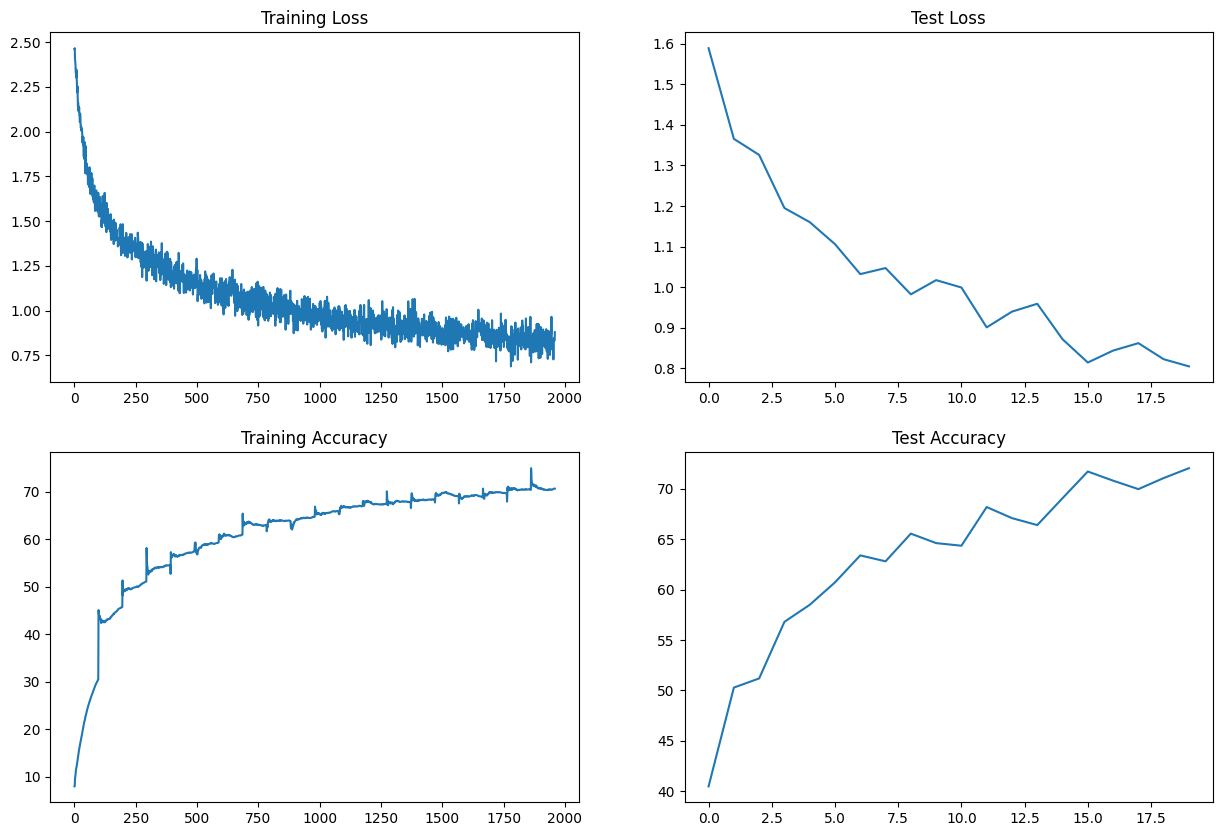

In [35]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [91]:
model.eval()
test_loss = 0
correct = 0
i =0
BN_misclassified_dict = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        #print('pred',pred)
        #print('target', target.view_as(pred))
        #print('test eq', pred.eq(target.view_as(pred)).sum().item())
        #print('test 1', pred.eq(target.view_as(pred)))
        #print('test 2', pred.eq(target.view_as(pred)).sum())
        #print('test 3', pred.eq(target.view_as(pred)).sum().item())
        #print('test 4', pred.shape)
        #print('test target', target.shape)
        #print('test data', data.shape)
        t = pred.eq(target.view_as(pred)).view(-1, target.size(0))
        t = t.cpu().numpy().reshape(-1)
        for ind,val in enumerate(t):
          if not val :
            temp_dict = {}
            temp_dict['data'] = data[ind].cpu().numpy()
            temp_dict['target'] = target[ind]
            temp_dict['pred'] = pred[ind]
            BN_misclassified_dict.append(temp_dict)

In [95]:
BN_misclassified_dict = BN_misclassified_dict[::-1]

In [155]:
def imshow1(img):
    # unnormalize
    #img[0] = img[0]*0.24703223 + 0.49139968
    #img[1] = img[1]*0.24348513 + 0.48215841
    #img[2] = img[2]*0.26158784 + 0.44653091
    #img = img*255
    img = img / 2 + 0.5
    #npimg = img.numpy()
    #plt.imshow(np.transpose(img, (1, 2, 0)))
    #plt.show()
    return np.transpose(img, (1, 2, 0))

In [140]:
0.84139156*255

214.5548478

In [ ]:
imshow1(BN_misclassified_dict[3]['data'])

Text(0.5, 1.0, 'cat')

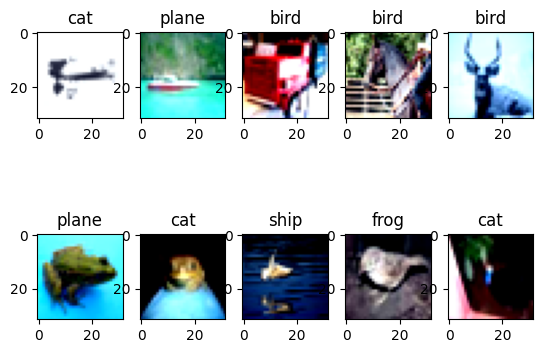

In [159]:
import random
f, axarr = plt.subplots(2,5)
i = random.randint(0,len(BN_misclassified_dict))
axarr[0,0].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[0,0].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[0,1].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[0,1].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[0,2].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[0,2].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[0,3].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[0,3].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[0,4].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[0,4].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[1,0].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[1,0].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[1,1].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[1,1].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[1,2].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[1,2].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[1,3].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[1,3].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(BN_misclassified_dict))
axarr[1,4].imshow(imshow1(BN_misclassified_dict[i]['data']))
axarr[1,4].set_title(classes[BN_misclassified_dict[i]['pred']], fontsize=12)

In [56]:
data.shape, target.shape, pred.shape

(torch.Size([272, 3, 32, 32]), torch.Size([272]), torch.Size([272, 1]))

In [87]:
classes[target[271]]

'truck'

In [ ]:
t = pred.eq(target.view_as(pred)).view(-1, target.size(0))
t = t.cpu().numpy().reshape(-1)
for ind,val in enumerate(t):
  if not val :
    print(ind, val)


In [74]:
print(data[271])

tensor([[[-0.5129, -0.5129, -0.4970,  ..., -0.3065, -0.3065, -0.2906],
         [-0.4811, -0.4811, -0.4811,  ..., -0.2589, -0.2747, -0.2589],
         [-0.4335, -0.4335, -0.4335,  ..., -0.2430, -0.2430, -0.2271],
         ...,
         [ 0.1539,  0.1539,  0.1697,  ...,  0.2650,  0.2491,  0.2809],
         [ 0.3602,  0.2809,  0.3126,  ...,  0.2809,  0.1856,  0.3444],
         [ 0.6460,  0.5984,  0.5984,  ...,  0.6619,  0.5825,  0.7095]],

        [[ 0.2263,  0.2263,  0.2263,  ...,  0.3873,  0.3873,  0.4034],
         [ 0.2585,  0.2585,  0.2585,  ...,  0.4357,  0.4196,  0.4357],
         [ 0.3229,  0.2907,  0.3068,  ...,  0.4518,  0.4518,  0.4679],
         ...,
         [ 0.4034,  0.4034,  0.4196,  ...,  0.4034,  0.3712,  0.4357],
         [ 0.7095,  0.6289,  0.6611,  ...,  0.5162,  0.4034,  0.5967],
         [ 1.0799,  1.0155,  1.0155,  ...,  0.9994,  0.9188,  1.0477]],

        [[ 0.9015,  0.8865,  0.9015,  ...,  0.9765,  0.9765,  1.0064],
         [ 0.9465,  0.9165,  0.9315,  ...,  1

In [82]:
np.transpose(data[271].cpu().numpy(), (1, 2, 0)).shape

(32, 32, 3)

In [83]:
data[271].cpu().numpy().shape

(3, 32, 32)

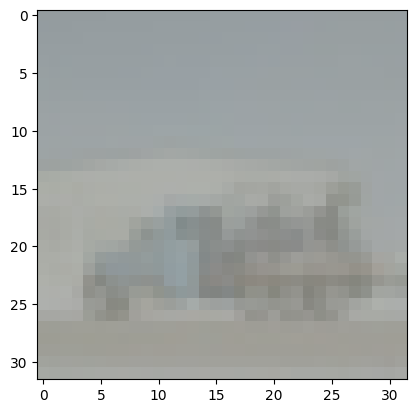

In [79]:
def imshow1(img):
    #img = img / 2 + 0.5     # unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    #npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
imshow1(data[271].cpu().numpy())
